In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sympy.solvers import solve
from sympy import Symbol

## Parameter setting

In [23]:
"""
    tau_tilde: time delay
    lambda_1: the first real coefficient of expansion of lambda
    alpha: weight coefficients
    f_n^_: partial derivative of f function at the equilibrium point (v_e,s_e,0)
    
"""

'\n    tau_tilde: time delay\n    lambda_1: the first real coefficient of expansion of lambda\n    alpha: weight coefficients\n    f_n^_: partial derivative of f function at the equilibrium point (v_e,s_e,0)\n    \n'

In [26]:
class CIDM(object):
    
    """
        Parameter defined in "Modeling and analyzing cyberattack 
        effects on connected automated vehicular platoons"
            
    """
    
    def __init__(self, N=15, ego_loc=6, M = 1):
        self.v_0 = 33.33
        self.l = 5
        self.T = 1.1
        self.s_0 = 2
        self.a = 1
        self.b = 2
        self.v = Symbol('v')
        self.R = 150
        self.N = N
        self.ego_loc = ego_loc
        self.alpha = [0.7,0.2,0.1]
        self.beta = [0.7,0.2,0.1] 
    
    def equilibrium_state_generation(self, profile_type, profile):
        
        result = []
        if profile_type == 'velocity':
            for data in tqdm(profile):
                result.append(self.equilibrium_headway(data))
                
        else:
            for data in profile:
                result.append(self.equilibrium_velocity(data))
                
        return result
                
              
    """
    Given the v*, calculate the s*

    """

    def equilibrium_headway(self, v_eq):

        s_eq = (self.s_0+self.T*v_eq)*(1-(v_eq/self.v_0)**4)**(-1/2)
        
        return s_eq
    
    """
    Given the s*, calculate the v*

    """

    def equilibrium_velocity(self, s_eq):

        v_eq = solve((self.s_0+self.T*self.v)*(1-(self.v/self.v_0)**4)**(-0.5)-s_eq, self.v)[0]
        
        return v_eq
    
     
    """
    Given the steady state, calculate the variables

    """

    def stable_condition_variable(self, v_eq, s_eq, A, B, C):

        term = C/(2*np.sqrt(self.a*self.b))

        f_nv = -4*self.a*(v_eq+A)**3/self.v_0**4 - 2*self.a*(self.s_0+self.T*(s_eq+A)+term*(v_eq+A))/(v_eq+B)**2*(self.T+term)
        f_ns = self.alpha[0]*2*self.a*(self.s_0+self.T*(v_eq+A)+term*(v_eq+A))**2/(s_eq+B)**3
        f_ndv = -self.beta[0]*np.sqrt(self.a/self.b)*(v_eq+A)*(self.s_0+self.T*(v_eq+A)+term*(v_eq+A))/(s_eq+B)**2
        lambda_1 = f_ns/f_nv

        return f_ns, f_nv, f_ndv, lambda_1
    
    
    
    """
    Calculate the linearly stable condition

    """

#     def characteristic_equation(self, f_ns, f_nv, f_ndv, lambda_1, tau_tilde):
        
#         result = -lambda_1**2/f_nv-lambda_1**2*tau_tilde + lambda_1*f_ndv/f_nv+f_ns/f_nv*\
#                 (1.4+lambda_1*tau_tilde-0.5)
            
#         return result 
    
    
#     def stability_equation(self, f_ns, f_nv, f_ndv, tau_tilde):
        
#         result = (f_nv/f_ns)**2*(1.4-0.5)+f_nv*f_ndv/f_ns**2*\
#                  1.4-1/f_ns+f_nv/f_ns*tau_tilde
        
#         return result
    
    
#     def degenerated_stability_equation(self, f_ns, f_nv, f_ndv):
        
#         result = -f_ns/f_nv+f_ndv+0.5*f_nv
        
#         return result
    
    
    
    def self_calculated_equation(self, f_ns, f_nv, f_ndv, lambda_1, tau_1, tau_2):
        
        lambda_2 = (-lambda_1**2/f_nv - lambda_1**2*tau_1 + lambda_1**2*f_ndv/f_nv*self.beta[0]*(tau_2-tau_1) + \
                    lambda_1*f_ndv/f_nv + lambda_1*(lambda_1*(self.alpha[0]*tau_1 + tau_2*sum(self.alpha[1:]))+0.9))
        
        return lambda_2

In [27]:
"""
    Given the different number of cooperative cars, the alpha vector changes accordingly.
    The attack is applied to the 5th car. The ego vehicle can take the last vehicle to the 6th vehicle
    For simplicity, we pick the 10th vehicle as the ego vehicle

"""

Test = CIDM()
# steady_velocity = Test.equilibrium_state_generation('headway', np.linspace(Test.s0,60,201))

In [28]:
Test.equilibrium_velocity(30)

22.4731266749452

In [114]:
f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(22.47, 30, -10, 25, -10)
lambda_2 = Test.self_calculated_equation(f_ns, f_nv, f_ndv, lambda_1, 5, 0.5)
lambda_2

0.45259274803724203

In [111]:
np.zeros([100,100])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

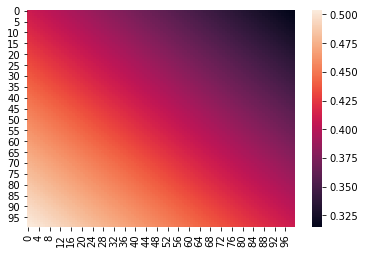

In [115]:
rr = np.zeros([100,100])
for idx_1, tt_1 in enumerate(np.arange(0, 10, 0.1)):
    for idx_2, tt_2 in enumerate(np.arange(0, 10, 0.1)):
        aaa = Test.self_calculated_equation(f_ns, f_nv, f_ndv, lambda_1, tt_1, tt_2)
        
        rr[idx_1, idx_2] = aaa
    
sns.heatmap(rr)
plt.savefig('noise_test.png')

In [82]:
v_eq = 22.47
s_eq = 30
term = 0/(2*np.sqrt(Test.a*Test.b))
-Test.beta[0]*np.sqrt(Test.a/Test.b)*(v_eq)*(Test.s_0+Test.T*(v_eq)+term*(v_eq))/(s_eq)**2

-0.33016519976644826

In [60]:
"""
    The equilibrium velocity varies from 10m/s to 45m/s
    Time delay varies from 0s to 5s

"""

headway = np.linspace(Test.s0,60,201)
y_tau = np.linspace(0,3,201)
result = np.zeros([201,201])

for idx_x, data in tqdm(enumerate(headway)):
    for idx_y, tau in enumerate(y_tau):
        f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(steady_velocity[idx_x], data)
        result[idx_x,idx_y] = Test.self_calculated_equation(f_ns, f_nv, f_ndv, lambda_1, tau)      

201it [00:35,  5.63it/s]


Text(84.5, 0.5, 'Headway /m')

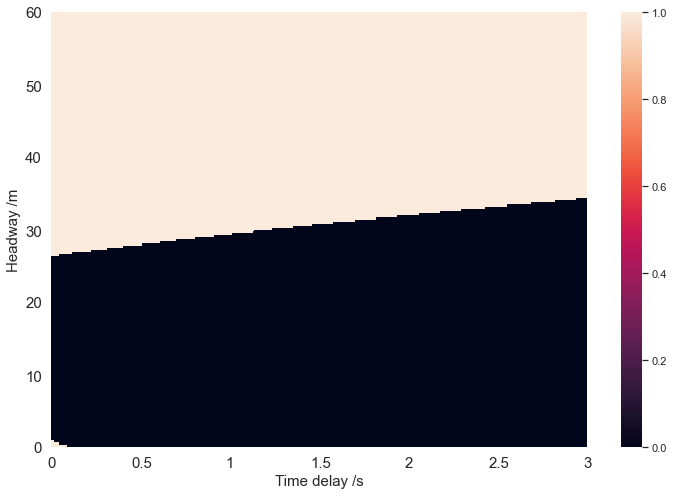

In [61]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(np.flip(result,axis=0)<=0)
plt.xticks([0, 34, 67, 101, 134,168,201], [0,0.5,1,1.5,2,2.5,3],rotation = 0,fontsize= 15)
plt.yticks([0, 34, 67, 101, 134,168,201], [60,50,40,30,20,10,0],rotation = 0,fontsize= 15)
plt.grid()
plt.xlabel("Time delay /s", fontsize=15)
plt.ylabel("Headway /m", fontsize=15)

In [123]:
s_eq = 10
# v_eq = solve((Test.s0+Test.T*Test.v)*(1-(Test.v/Test.v0)**4)**(-0.5)-s_eq, Test.v)[0]
v_eq = solve((2+1*Test.v)*(1-(Test.v/24)**4)**(-0.5)-s_eq, Test.v)[0]

In [112]:
f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(v_eq, s_eq)
rr = Test.stability_equation(f_ns, f_nv, f_ndv, 0.5)   
rr

0.494618402910831

In [83]:
Test.characteristic_equation(f_ns, f_nv, f_ndv, lambda_1, 0.5) 

24

In [124]:
v_eq

7.93992455108470

In [450]:
# headway = np.linspace(Test.s0,150,201)
rlt = []

for idx, data in tqdm(enumerate(headway)):

    f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(steady_velocity[idx], data)
    rlt.append(Test.self_calculated_equation(f_ns, f_nv, f_ndv, lambda_1, 0))

201it [00:00, 446.66it/s]


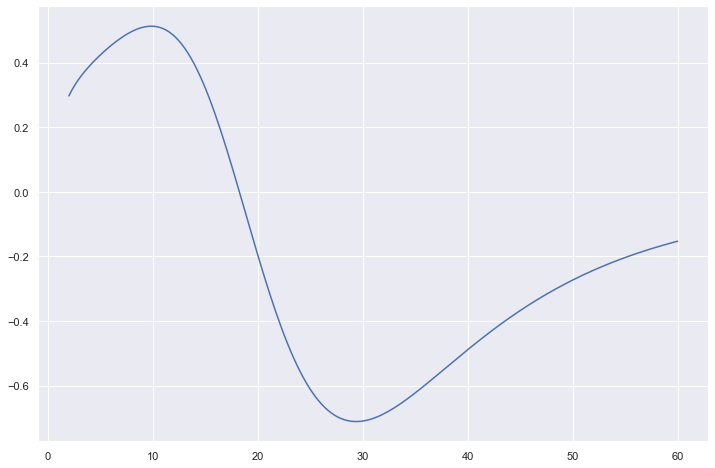

In [451]:
plt.plot(headway, rlt)

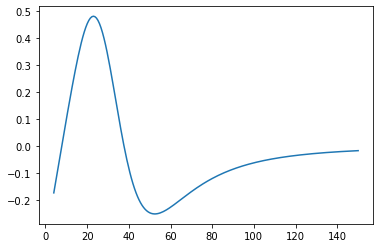

In [414]:
plt.plot(headway, result[:,0])

In [402]:
result

array([[-4.98928852e+01, -4.98928852e+01, -4.98928852e+01, ...,
        -4.98928852e+01, -4.98928852e+01, -4.98928852e+01],
       [-4.09301546e+01, -4.09301546e+01, -4.09301546e+01, ...,
        -4.09301546e+01, -4.09301546e+01, -4.09301546e+01],
       [-3.43471904e+01, -3.43471904e+01, -3.43471904e+01, ...,
        -3.43471904e+01, -3.43471904e+01, -3.43471904e+01],
       ...,
       [-1.73994879e-02, -1.73994879e-02, -1.73994879e-02, ...,
        -1.73994879e-02, -1.73994879e-02, -1.73994879e-02],
       [-1.71311399e-02, -1.71311399e-02, -1.71311399e-02, ...,
        -1.71311399e-02, -1.71311399e-02, -1.71311399e-02],
       [-1.68682166e-02, -1.68682166e-02, -1.68682166e-02, ...,
        -1.68682166e-02, -1.68682166e-02, -1.68682166e-02]])

(0.0, 12.6696809268637)

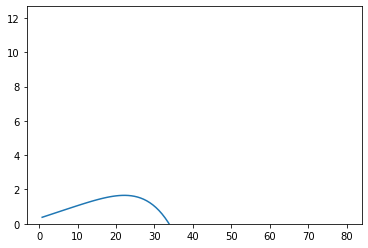

In [289]:
plt.plot(headway,[-i for i in rlt])

plt.ylim(ymin = 0)

In [259]:
headway = np.linspace(4,80,101)
rlt = []

for data in tqdm(headway):
    
    veq = Test.equilibrium_velocity(data)
    f_ns, f_nv, f_ndv, lambda_1 = Test.stable_condition_variable(veq, data)
    rlt.append(Test.degenerated_stability_equation(f_ns, f_nv, f_ndv))

100%|██████████████████████████████████████████████████████████████████████████| 101/101 [01:16<00:00,  1.32it/s]


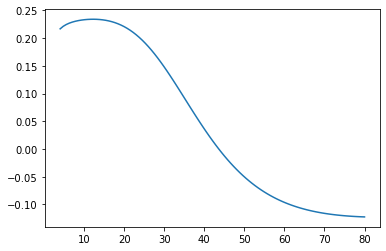

In [260]:
plt.plot(headway,rlt)

In [ ]:
def stable_condition_variable(self, v_eq, s_eq, A, B, C):
    
    term = C/(2*np.sqrt(self.a*self.b))
    
    f_nv = -4*self.a*(v_eq+A)**3/v_0**4 - 2*self.a*(s_0+self.T*(s_eq+A)+term*(v_eq+A))/(v_eq+B)**2*(self.T+term)
    f_ns = self.alpha[0]*2*self.a*(s_0+self.T*(v_eq+A)+term*(v_eq+A))**2/(s_eq+B)**3
    f_ndv = -self.beta[0]*np.sqrt(self.a/self.b)*(v_eq+A)*(s_0+self.T*(v_eq+A)+term*(v_eq+A))/(s_eq+B)**2
    lambda_1 = f_ns/f_nv

    return f_ns, f_nv, f_ndv, lambda_1

In [ ]:
f_nv = -4*self.a*(v_eq+A)**3/v_0**4 - 2*self.a*(s_0+self.T*(s_eq+A)+term*(v_eq+A))/(v_eq+B)**2*(self.T+term)
f_ns = alpha[0]*2*self.a*(s_0+self.T*(v_eq+A)+term*(v_eq+A))**2/(s_eq+B)**3
f_ndv = -beta[0]*np.sqrt(self.a/self.b)*(v_eq+A)*(s_0+self.T*(v_eq+A)+term*(v_eq+A))/(s_eq+B)**2